In [24]:
import os
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import time
from copy import deepcopy
from utils import stratify

split = 0.7
np.random.seed(seed=0)

ft_dir = 'features_long/'

files = os.listdir(ft_dir)

with open('top_locations.dat', 'rb') as f:
    location_top = pickle.load(f)
f.close()

feature_all = []
target_all = []

for filename in files:
    with open(ft_dir+filename, 'rb') as f:  
        feature, target = pickle.load(f)

        # only keeping locations in location_top and encoding them
        ind = np.array([], int)
        for (i,loc) in enumerate(target['location']):
            if loc in location_top:
                ind = np.append(ind, i)
                target.loc[i,'elocation'] = np.where(location_top==loc)[0]
        feature = feature.loc[ind,:]
        target = target.loc[ind]
        feature = feature.reset_index(drop=True)
        target = target.reset_index(drop=True)
        
        # change encoded column data type to int
        target['elocation'] = target['elocation'].astype(int)
        
        feature_all.append(feature)
        target_all.append(target)
        
    f.close()

inds = np.arange(0,len(feature_all),1)
inds_split = int(np.floor(split*len(feature_all)))
    
# training set
np.random.shuffle(inds)
ind_train = inds[:inds_split]
ind_test = inds[inds_split:]

x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
y_train = pd.concat([target_all[j]['elocation'] for j in ind_train], axis=0)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# stratification
(x_train, y_train) = stratify(x_train, y_train)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=10, learning_rate=0.025, nthread=12, subsample=0.25, \
                    colsample_bytree=0.2, max_delta_step=0, gamma=0.4, objective='mlogloss', reg_alpha=0, \
                    reg_lambda=1, missing=np.nan, min_child_weight=4)

gbm.fit(np.array(x_train), np.array(y_train))



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.4, learning_rate=0.025, max_delta_step=0, max_depth=3,
       min_child_weight=4, missing=None, n_estimators=10, nthread=12,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.25)

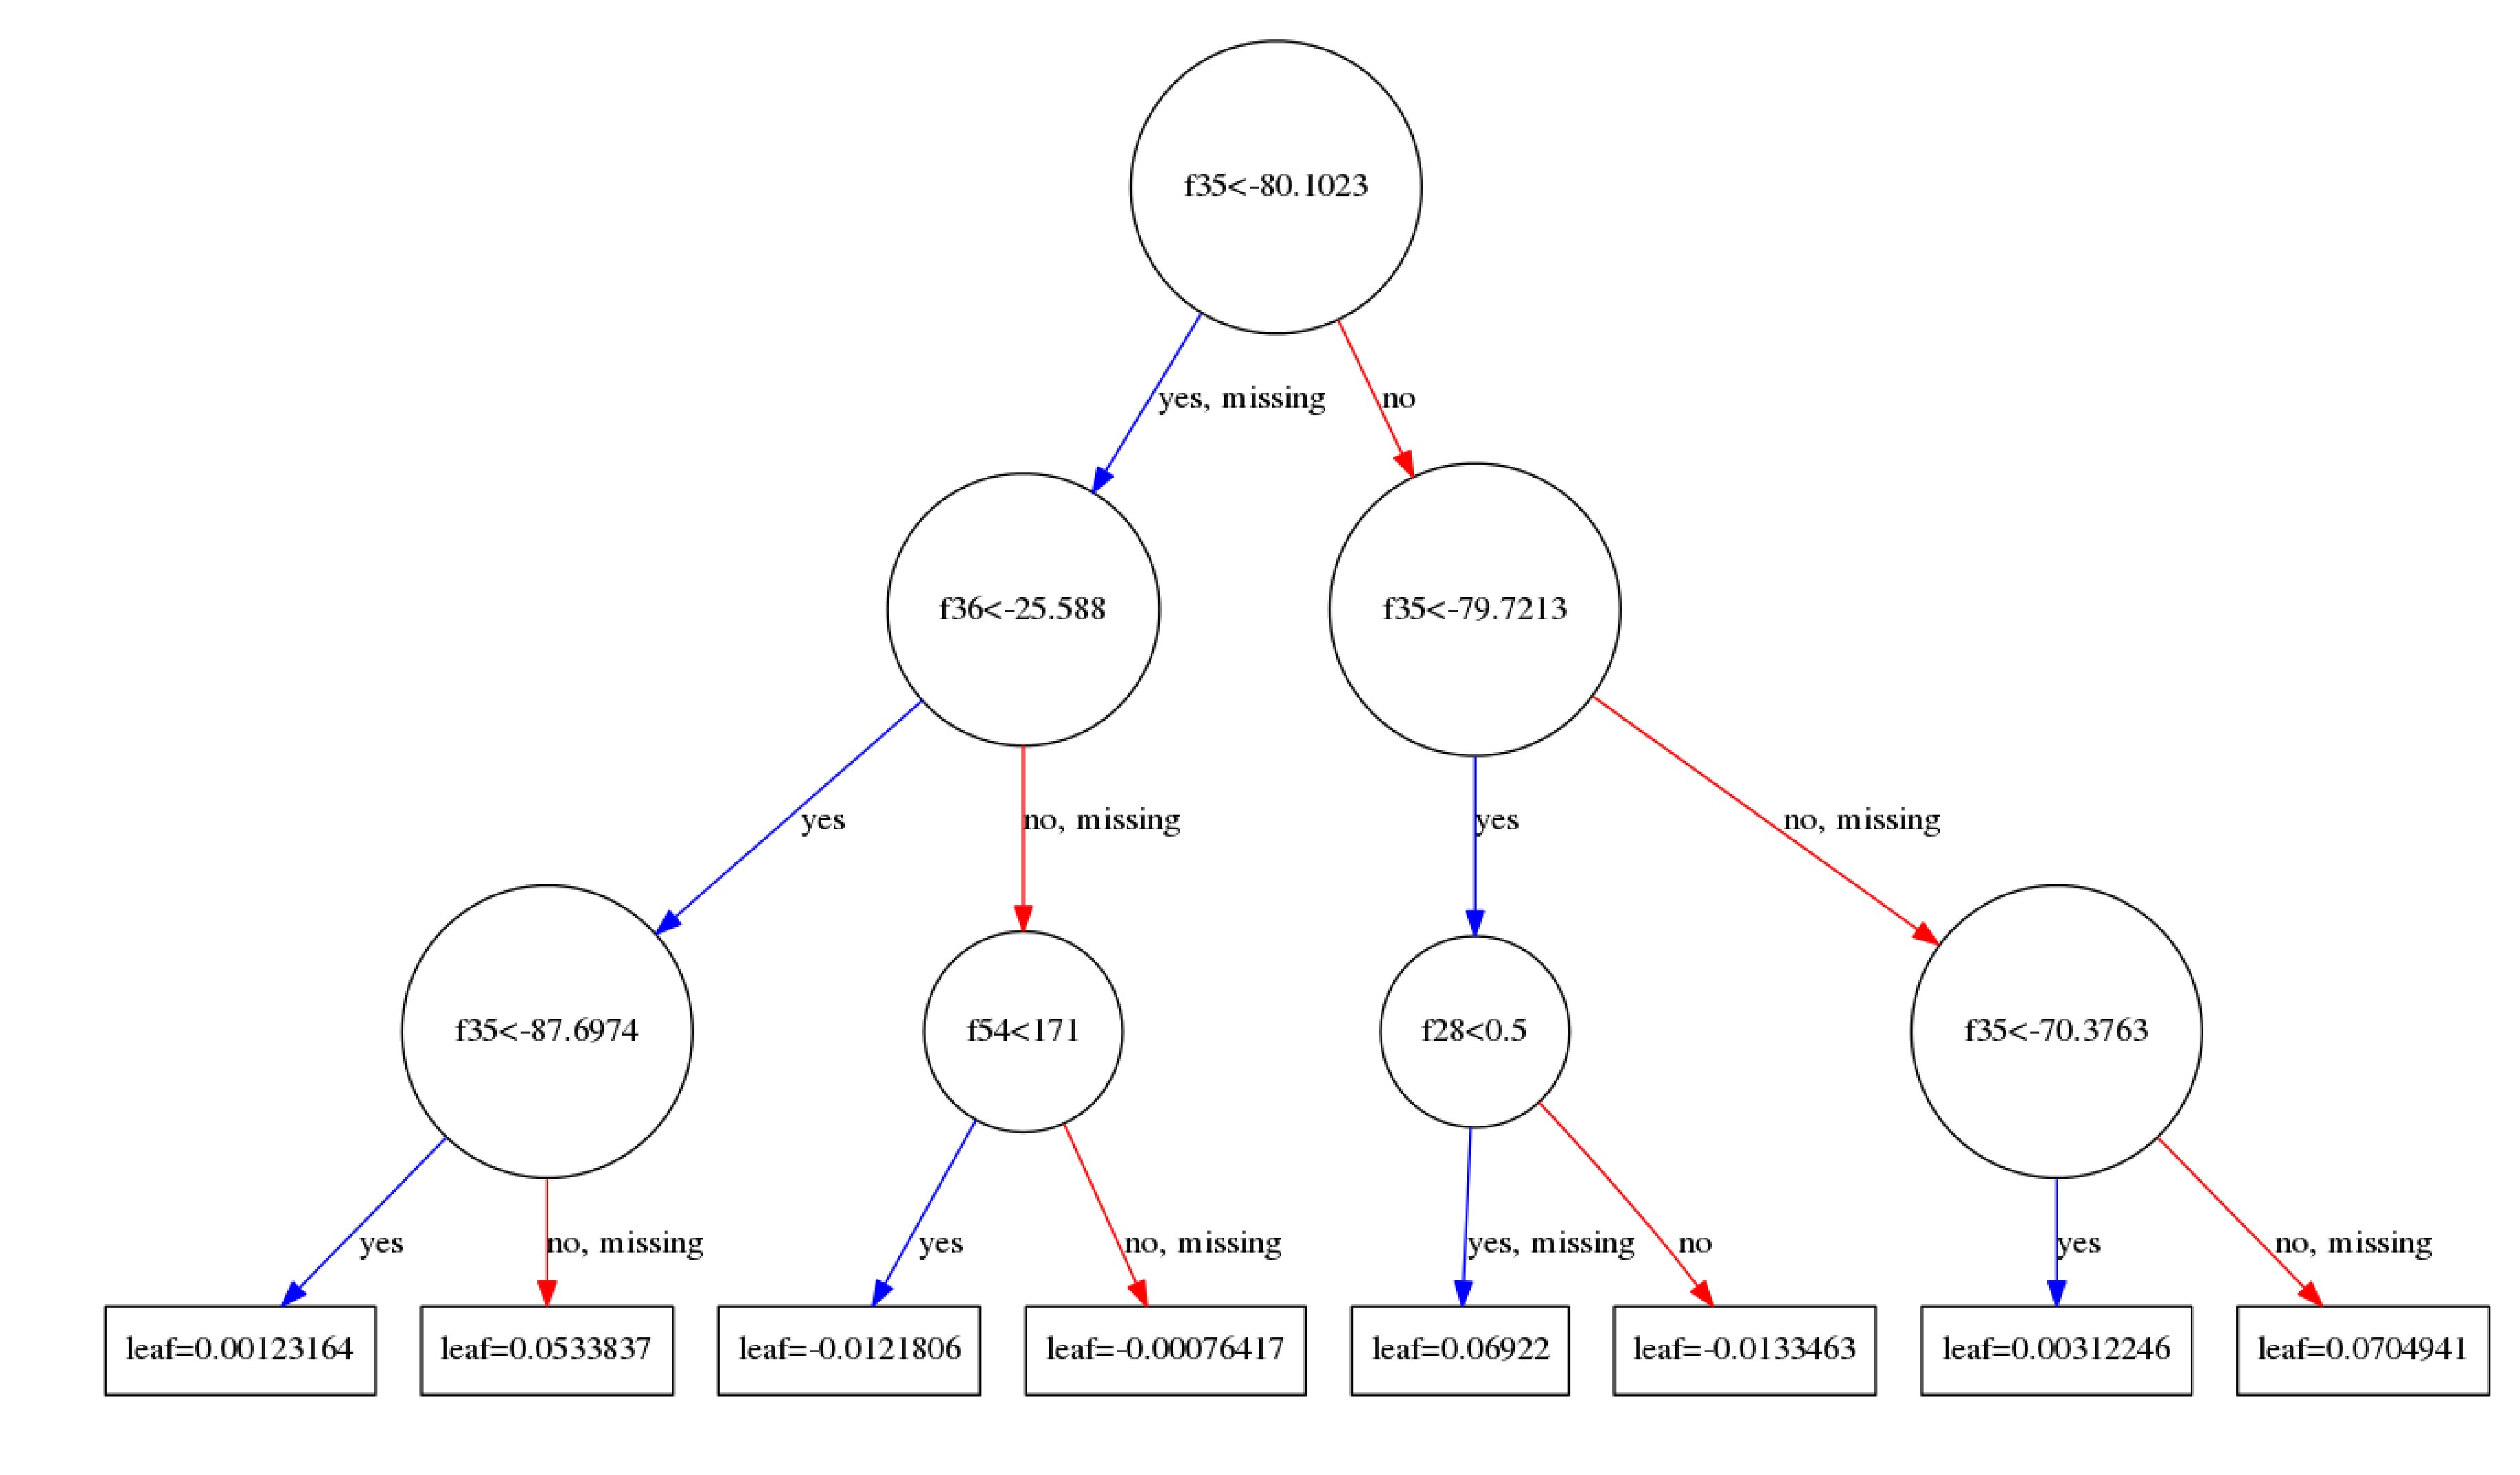

In [34]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[15,12],dpi=300)
plot_tree(gbm, num_trees=0, ax=plt.gca(), rankdir='UT')